In [1]:
import sys
sys.path.append('.')

import os
import random

import torch
import torch.utils.data as data
import numpy as np
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
MAX_NUM_OBJ = 64
MEAN_COLOR_RGB = np.array([109.8, 97.2, 83.8])

class ScanNetObjPairScoreCls(data.Dataset):

    def __init__(self, split_set='train',
        use_color=False, use_height=False, augment=False):

        self.data_path = '/home1/peisheng/3detr/scannet_data/scannet/scannet_train_detection_data'
        all_scan_names = list(set([os.path.basename(x)[0:12] \
            for x in os.listdir(self.data_path) if x.startswith('scene')]))
        if split_set=='all':
            self.scan_names = all_scan_names
        elif split_set in ['train', 'val', 'test']:
            split_filenames = os.path.join('/home1/peisheng/3detr/scannet_data/scannet/meta_data',
                'scannetv2_{}.txt'.format(split_set))
            with open(split_filenames, 'r') as f:
                self.scan_names = f.read().splitlines()
            # remove unavailiable scans
            num_scans = len(self.scan_names)
            self.scan_names = [sname for sname in self.scan_names \
                if sname in all_scan_names]
            print('kept {} scans out of {}'.format(len(self.scan_names), num_scans))
            num_scans = len(self.scan_names)
        else:
            print('illegal split name')
            return

        self.use_color = use_color
        self.use_height = use_height
        self.augment = augment

        # the code above is for scenes, the code below is for objects
        self.object_path = '/home1/peisheng/occulusion_sim/DODA/scannet_object_complete_partial'
        # loop through all the scenes
        self.scene_object_dict = {}

        # remove scene0444_01 from the list because there is an error with camera locs
        if 'scene0444_01' in self.scan_names:
            self.scan_names.remove('scene0444_01')

        for scan_name in self.scan_names:
            current_file_name = os.path.join(self.object_path, scan_name + '.npy')
            scene_objects = np.load(current_file_name, allow_pickle=True).item()
            self.scene_object_dict[scan_name] = scene_objects

        # scene_objects is a dictionary where the key is the index of the object in the scene, and the value is a dictionary
        # with 2 keys: 'complete' and 'partial', where 'complete' has a value of a numpy array of the indexes of points for the
        # complete object, and 'partial' has a value of a list of numpy arrays of the indexes of points for the partial objects.
        # the length of the dataset is the number of all the partial objects in all the scenes.

        # construct a mapping from dataset index to scene name and complete and partial object index
        # the mapping should be (scene name, complete object index, partial object index)
        self.index_to_scene_object = []
        for scan_name in self.scan_names:
            scene_objects = self.scene_object_dict[scan_name]
            for k, v in scene_objects.items():
                if len(v['partial']) > 0:
                    for i, partial_object_point_index in enumerate(v['partial']):
                        self.index_to_scene_object.append((scan_name, k, i))

    def __getitem__(self, index):

        scan_name = self.index_to_scene_object[index][0]
        mesh_vertices = np.load(os.path.join(self.data_path, scan_name)+'_vert.npy')
        instance_bboxes = np.load(os.path.join(self.data_path, scan_name)+'_bbox.npy')

        scan_name, complete_index, partial_index = self.index_to_scene_object[index]
        complete_object_point_index = self.scene_object_dict[scan_name][complete_index]['complete']
        partial_object_point_index = self.scene_object_dict[scan_name][complete_index]['partial'][partial_index]

        # index of the object is the complete object index. Get the class label of the object
        class_label = instance_bboxes[complete_index][-1]
        # convert to int
        class_label = int(class_label)
        # to tensor
        class_label = torch.tensor(class_label, dtype=torch.long)

        if not self.use_color:
            point_cloud = mesh_vertices[:,0:3] # do not use color for now
            pcl_color = mesh_vertices[:,3:6]
        else:
            point_cloud = mesh_vertices[:,0:6]
            point_cloud[:,3:] = (point_cloud[:,3:]-MEAN_COLOR_RGB)/256.0

        complete_object_point_cloud = point_cloud[complete_object_point_index]
        partial_object_point_cloud = point_cloud[partial_object_point_index]

        # score is the ratio of the number of points in the partial object to the number of points in the complete object
        score = partial_object_point_cloud.shape[0] / complete_object_point_cloud.shape[0]
        # convert to torch tensor
        score = torch.tensor(score, dtype=torch.float32)

        # normalize complete object point cloud
        complete_object_point_cloud[:,0:3], complete_centroid, complete_m = self.normalize_point_cloud(complete_object_point_cloud[:,0:3])

        # use complete object centroid and m to normalize partial object point cloud
        partial_object_point_cloud[:,0:3] = (partial_object_point_cloud[:,0:3] - complete_centroid) / complete_m

        # partial_pc = self.random_sample(partial_object_point_cloud, 2048) # TODO these two numbers might need to be changed
        # complete_pc = self.random_sample(complete_object_point_cloud, 16384)


        # return torch.from_numpy(partial_pc), torch.from_numpy(complete_pc), score, class_label
        return torch.from_numpy(partial_object_point_cloud), torch.from_numpy(complete_object_point_cloud), score, class_label

    def __len__(self):
        return len(self.index_to_scene_object) # 154751
    # 20 times more than shapenet, so should use 1/20 epoch number, and save every 1 epoch.

    def random_sample(self, pc, n):
        idx = np.random.permutation(pc.shape[0])
        if idx.shape[0] < n:
            idx = np.concatenate([idx, np.random.randint(pc.shape[0], size=n-pc.shape[0])])
        return pc[idx[:n]]

    def normalize_point_cloud(self, pc):
        centroid = np.mean(pc, axis=0)
        pc = pc - centroid
        m = np.max(np.sqrt(np.sum(pc**2, axis=1)))
        pc = pc / m
        return pc, centroid, m


In [6]:
dataset = ScanNetObjPairScoreCls('train')
ds_len = len(dataset)
partial_num_pt_list = []
complete_num_pt_list = []
for i in range(ds_len):
    if i % 1000 == 0:
        print(i)
    partial_pc, complete_pc, score, class_label = dataset[i]
    partial_num_pts = partial_pc.shape[0]
    complete_num_pts = complete_pc.shape[0]
    partial_num_pt_list.append(partial_num_pts)
    complete_num_pt_list.append(complete_num_pts)

partial_num_pt_list = np.array(partial_num_pt_list)
complete_num_pt_list = np.array(complete_num_pt_list)

kept 1199 scans out of 1201
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000


In [9]:
# average partial_num_pt_list
partial_num_pt_list.mean()

869.5723194034288

In [10]:
# average complete_num_pt_list
complete_num_pt_list.mean()

2223.018597618109

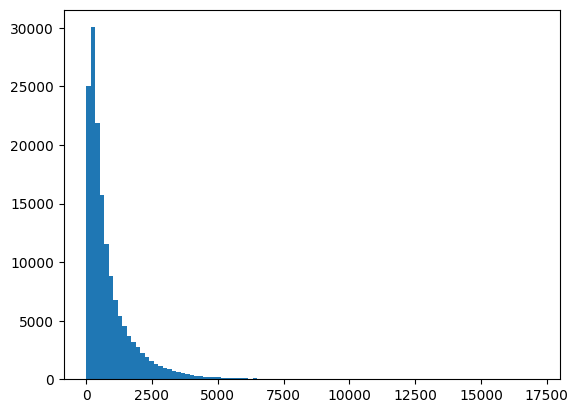

mean: 869.5723194034288, std: 1011.6020020721073


519.0

In [15]:
# plot the distribution of the number of points in the partial object
import matplotlib.pyplot as plt
plt.hist(partial_num_pt_list, bins=100)
plt.show()

# print the mean and std of the number of points in the partial object
partial_num_pt_list.mean()
partial_num_pt_list.std()
print('mean: {}, std: {}'.format(partial_num_pt_list.mean(), partial_num_pt_list.std()))

# print the median of the number of points in the partial object
np.median(partial_num_pt_list)

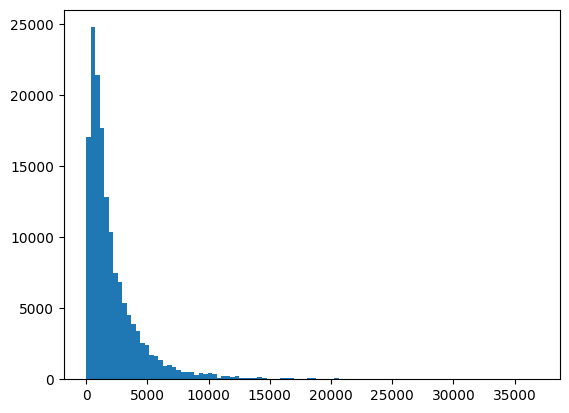

mean: 2223.018597618109, std: 2570.521462461467


1397.0

In [16]:
# repeat for the complete object
plt.hist(complete_num_pt_list, bins=100)
plt.show()

complete_num_pt_list.mean()
complete_num_pt_list.std()
print('mean: {}, std: {}'.format(complete_num_pt_list.mean(), complete_num_pt_list.std()))

# print median of the number of points in the complete object
np.median(complete_num_pt_list)

In [ ]:
# how many points do shapenet have?
# complete 16384, and all points are sampled.
# partial: the max is 2047. mean 1175, std 340, median 1138

In [14]:
complete_num_pt_list.mean() + 3 * complete_num_pt_list.std()

9934.58298500251